In [16]:
#final_ab = [11954.610678565705, 26640.154472739254, -31077.877327182145, -1867.588306476446, 30629.702793302644, -20495.80246825456, -14059.962757966152, 29071.142977218868, -6684.614715660674, -22878.049137154325, 20651.511097353185, 8980.32775916874, -24086.34579262101, 4230.844997777144, 20251.701816267567, -11914.08712367016, -14849.31579936722, 13546.223921558538, 12091.576139457724, -10091.688205362158, -13183.601239877862, -2180.3507527896572, 2939.6830976793976, 1660.5818186622241, 272.018150027415, -37572.0166160675, 17675.925924146937, 25980.861919426894, -39622.62097540796, 3705.8297244388923, 39185.788041316286, -34695.971276433185, -15529.839771176934, 48742.38630114164, -19098.839842992835, -39164.84461806948, 47055.744740830465, 11885.277879311338, -58638.00164913768, 19098.135244837053, 54853.25282210304, -43832.053941940554, -47690.7959421055, 58103.02090466664, 54860.21741263866, -53853.63700751572, -100401.69700601425, -60724.29623986513, -17047.259991361363, -1839.3074102001062]
#H=16
final_ab = [720286.6924392559, -354853.47926858417, -474194.66318958555, 539781.693529648, 200172.90544731152, -567348.4616019353, -6106.975636721118, 526869.9129633734, -59784.50752382071, -505052.35775471164, -49539.48342270882, 486572.2135816192, 492810.5846176217, 233143.1512834134, 57850.020401061534, 6147.920357687593, -9281.482801129645, -801933.9586723814, 474022.71718459023, 633430.9895442324, -889019.4154266276, -252376.79309961558, 1.1415796146259091e6, -196423.8777599085, -1.2656352455844877e6, 530476.6388555119, 1.4846134545359355e6, -440480.10484219075, -2.129698447618326e6, -1.7050605666812279e6, -607523.8266279303, -85692.97929263428]
#H=20
#final_ab = [-30400.889099683725, 71546.01935013998, -31008.501274736936, -40044.92128965587, 60227.96427857853, -10423.62757346723, -47056.10471887403, 43668.38218528986, 12723.044154464587, -47837.63395278975, 16584.149561081114, 34471.72055178346, -29620.000266956817, -21003.487615868526, 29293.670486130366, 18050.314114741275, -18089.583812984158, -21986.47951757809, -8462.56048638424, -1177.0222721871464, -51100.604726602134, 80135.26994607033, -16743.96865981239, -73559.8752885189, 85177.6038241561, 6008.84126278702, -100794.32632210453, 79437.13961283144, 48672.167366750065, -129215.34801683467, 39832.3306954088, 123389.88730780222, -121372.22550811827, -87654.80186338522, 179846.88128196297, 83722.86030014827, -223086.64450841642, -270916.56361362507, -119912.53865886356, -19811.946467807364]
#H=30
#final_ab = [-32293.0069986134, 35040.918549314156, 1807.7951927521092, -35168.91586913364, 27370.436150954058, 11039.325634341973, -35065.77023187822, 18019.107209019996, 18709.819058441997, -32185.260702527277, 7996.511254828879, 24335.969346986192, -26963.60974859367, -2204.832887536783, 27857.650602959966, -19257.923624970528, -12911.616460637762, 28588.6277630294, -7225.670621779325, -24115.595891907185, 22363.490962694726, 12447.559751643359, -29332.807874596874, -2400.3242369116047, 32195.52504220483, 2237.7707556790233, -36169.89746185072, -32533.106468746748, -11949.154559224835, -1687.258718086808, -8060.838834152027, 40205.09352617898, -26985.398035609283, -17200.16393489015, 42599.68698330343, -20410.63928079521, -24890.68908158155, 42976.384270865994, -13507.359771605492, -31454.7510469488, 42421.98582858524, -6405.42984067134, -38054.62710776764, 41456.51586601013, 2332.2858719498913, -46143.01849320798, 38588.921212112975, 16148.051185826795, -55717.567076970125, 27941.081980149473, 39681.96629723879, -59995.868703470675, -4447.615743188323, 70397.97281067233, -28089.55162021017, -73471.54151244747, 39698.334516347786, 106306.6797170131, 60912.71106396135, 11937.683289592736]
;

In [2]:
using SparseIR
using PyPlot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"
using LinearAlgebra
using Revise
using Optim
using FFTW
#using ForwardDiff
using Zygote
#using Flux
include("./src/Nevanlinna.jl")

Main.Nevanlinna

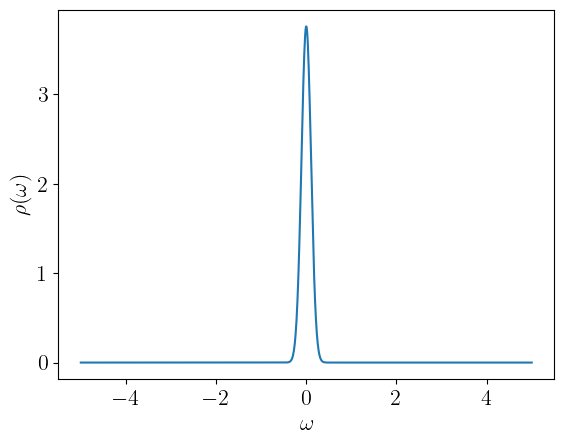

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x14e73e4604f0>

In [3]:
# Three Gaussian peaks (normalized to 1)
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

#rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

rho(omega) = gaussian(omega, 0.0, 0.15)
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)


omegas = LinRange(-5, 5, 1000)
plt.xlabel(L"\omega")
plt.ylabel(L"\rho(\omega)")
plt.plot(omegas, rho.(omegas))

In [4]:
beta = 100
wmax = 1000
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-7)
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;
#=
plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
#plt.legend()
=#

In [5]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = Int64(length(IR_basis_set.smpl_wn_f.sampling_points)/2)

37

In [6]:
setprecision(128)

128

In [7]:
test_gw   = Array{Complex{BigFloat}}(undef, hnw) 
test_smpl = Array{BigFloat}(undef, hnw) 
;

In [8]:
for i in 1:hnw
    test_smpl[i]= parse(BigFloat, string(IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta))
    test_gw[i]  = parse(BigFloat, string(real(gw[hnw+i]))) + parse(BigFloat, string(imag(gw[hnw+i])))*im
end

In [17]:
N_imag    =  12
N_real    =  6000
omega_max =  10.0
eta       =  0.001
H         =  16
ab_coeff = zeros(Float64, 2*H) 

imaginary = Nevanlinna.ImagDomainData(N_imag, test_smpl, test_gw)
pre_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta)
reals     = Nevanlinna.RealDomainData(N_real, omega_max, eta)

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(reals, H)

Nevanlinna.evaluation(imaginary, pre_reals, abcd, H, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.


In [11]:
#Nevanlinna.calc_functional(reals, abcd, H, ab_coeff, hardy_matrix)
Nevanlinna.calc_functional(reals, abcd, H, final_ab, hardy_matrix)

9.502720958556207

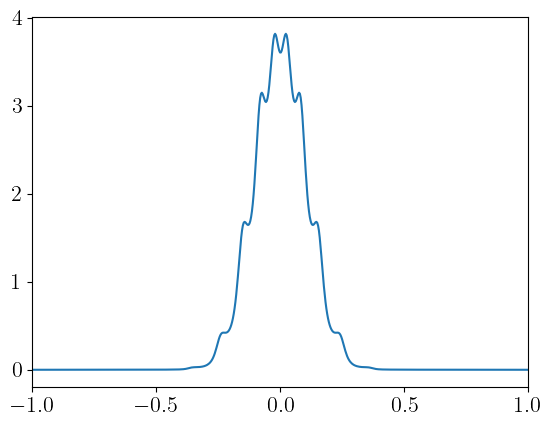

(-1.0, 1.0)

In [12]:
plt.plot(Float64.(real.((pre_reals.freq))), Float64.(imag.(pre_reals.val))/pi)
plt.xlim(-1.0,1.0)

In [12]:
f = x->Nevanlinna.calc_functional(reals, abcd, H, x, hardy_matrix)

#3 (generic function with 1 method)

In [15]:
@time jtest = gradient(f, ab_coeff)

 21.449517 seconds (56.77 M allocations: 3.140 GiB, 6.83% gc time, 96.66% compilation time)


([-0.00020564384372339422, 0.00015430901128191699, -0.00010180615282356939, 5.065012028312811e-5, -3.1922553540797706e-6, -3.8590179617812446e-5, 7.325321608525659e-5, -9.997541972165696e-5, 0.00011857068142841784, -0.0001294305217706258  …  0.0003155041115398074, -0.0002949478837736789, 0.000274068387942286, -0.0002535976755919049, 0.0002340428876422816, -0.00021571520331090848, 0.00019876686924402129, -0.00018322889469975516, 0.0001690449470603902, -0.00015609988639335922],)

In [16]:
function j(J::Vector, x)
   J .= gradient(f, x)[1] 
end

j (generic function with 1 method)

In [ ]:
@time res = optimize(f, j, ab_coeff, BFGS())
#@time res = optimize(f, ab_coeff, ConjugateGradient())

In [19]:
#Nevanlinna.evaluation(imaginary, reals, abcd, H, Optim.minimizer(res), hardy_matrix)
Nevanlinna.evaluation(imaginary, reals, abcd, H, final_ab, hardy_matrix)
;

In [ ]:
Optim.minimizer(res)

In [ ]:
println(res)

In [ ]:
#=
param_f = open( "optim_param.dat", "w")
for i in 1:2*H
    println(param_f, "$(Optim.minimizer(res)[i])")
end
close(param_f)
=#

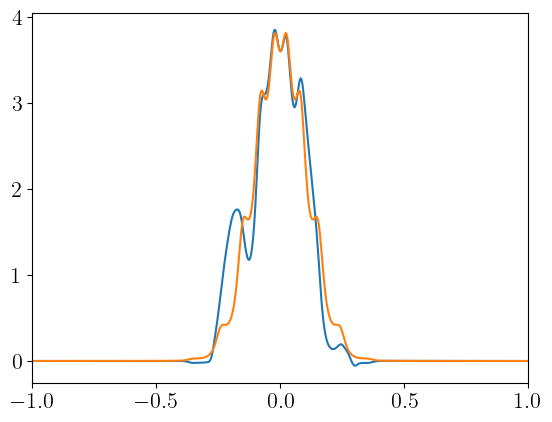

(-1.0, 1.0)

In [20]:
plt.plot(Float64.(real.((reals.freq))), Float64.(imag.(reals.val))/pi)
plt.plot(Float64.(real.((pre_reals.freq))), Float64.(imag.(pre_reals.val))/pi)
plt.xlim(-1.0,1.0)

In [ ]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [ ]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#